In [84]:
import random

import numpy as np
import json
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy.distance as distance
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.markers as markers
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from random import choice
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [43]:
regions_path = "data/regions/UKR_adm1.shp"
cities_path = "data/preprocessed/cities.csv"
destinations_path = "data/preprocessed/destinations.csv"

### Plot Ukraine map with regions

In [49]:
df_regions = gpd.read_file(regions_path)
df_regions.head()


,ID_0,ISO,NAME_0,ID_1,NAME_1,REGION,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,240,UKR,Ukraine,1,Cherkasy,Cherkaska,UA.CK,0,None,Oblast',Region,None,Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy,"POLYGON ((32.15047 50.19769, 32.15050 50.19181..."
1,240,UKR,Ukraine,2,Chernihiv,Chernihivska,UA.CH,0,None,Oblast',Region,None,Chernigov|Tschernigow,"POLYGON ((33.19667 52.37500, 33.20612 52.36700..."
2,240,UKR,Ukraine,3,Chernivtsi,Chernivetska,UA.CV,0,None,Oblast',Region,None,Chernivets'ka Oblast'|Chernovitskaya Oblast'|C...,"POLYGON ((25.62595 48.67673, 25.64460 48.67159..."
3,240,UKR,Ukraine,4,Crimea,Crimea,UA.KR,0,None,Autonomous Republic,Autonomous Republic,None,CrimÃ©e|CrimÃ©ia|Krim|Krymskaya Respublika|Res...,"MULTIPOLYGON (((33.79458 44.39153, 33.79291 44..."
4,240,UKR,Ukraine,5,Dnipro,Dnipropetrovska,UA.DP,0,None,Oblast',Region,None,Dnipropetrovsk|Dniepropietrovsk|Dnjepropetrowsk,"POLYGON ((34.92995 49.15574, 34.92076 49.14992..."


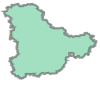

In [50]:
# there is a separate polygon shape fot Kiev city, excluded from its region
# merge them into one region and remove the city
merged_kyiv = unary_union(df_regions[df_regions['NAME_1'].isin(['Kyiv', 'Kyiv City'])]['geometry'])
df_regions = df_regions.drop(df_regions[df_regions['NAME_1'] == 'Kyiv City'].index)
df_regions.loc[df_regions['NAME_1'] == 'Kyiv', 'geometry'] = merged_kyiv

merged_kyiv

In [51]:
# set of already existing warehouses
warehouses = frozenset({'Lviv', 'Kyiv', 'Kherson'})
# cities for new warehouses
possible_warehouses = set(df_regions['NAME_1'].to_numpy()).difference(warehouses).difference({'Crimea', 'Sevastopol'})

In [52]:
df_cities = pd.read_csv(cities_path)

points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_cities['location'].to_numpy())]

df_cities = GeoDataFrame(df_cities, geometry=points, crs=df_regions.crs)
df_cities.head()

,name,location,population,latitude,longitude,region,geometry
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904,46.91562,37.09961,Donetska,POINT (37.09961 46.91562)
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121,48.0114,38.26444,Donetska,POINT (38.26444 48.01140)
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608,49.80597,24.89436,Lvivska,POINT (24.89436 49.80597)
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0,49.38468,24.14254,Lvivska,POINT (24.14254 49.38468)
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783,45.69028,33.52775,Crimea,POINT (33.52775 45.69028)


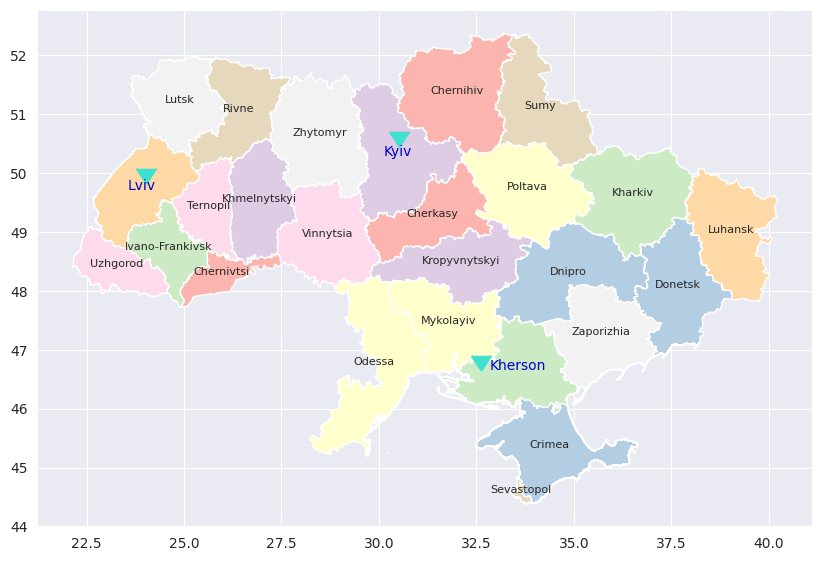

In [53]:
def plot_map(df, ax: plt.axes = None, new_warehouses: frozenset[str] = frozenset()) -> None:
    ax = df.plot(ax=ax, cmap='Pastel1', figsize=(10, 10))

    # add regions names into the center of each shape
    df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8) if x['NAME_1'] not in warehouses.union(new_warehouses) else None, axis=1)

    old_warehouses_points = df_cities[df_cities['name'].isin(warehouses)]
    old_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='turquoise')
    df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='mediumblue', fontsize=10) if x['NAME_1'] in warehouses else None, axis=1)

    if len(new_warehouses) > 0:
        new_warehouses_points = df_cities[df_cities['name'].isin(new_warehouses)]
        new_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='red')
        df.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='crimson', fontsize=10) if x['NAME_1'] in new_warehouses else None, axis=1)

    # highlight the existing warehouses with a balder outline
    # df.loc[df['NAME_1'].isin(warehouses)].plot(ax=ax, facecolor='none', edgecolor='turquoise', linewidth=1)

plot_map(df_regions)

### Parse cities coordinates from the Tarilka's report

In [8]:
df_destinations = pd.read_csv(destinations_path)

points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_destinations['location'].to_numpy())]

df_destinations = GeoDataFrame(df_destinations, geometry=points, crs=df_regions.crs)

df_destinations.head()

,name,location,region,capacity,geometry
0,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",Lvivska,4,POINT (24.89436 49.80597)
1,Druzhkivka,"{""__type"":""GeoPoint"",""latitude"":48.63013,""long...",Donetska,25,POINT (37.55259 48.63013)
2,Lebedyn,"{""__type"":""GeoPoint"",""latitude"":50.58518,""long...",Sumska,4,POINT (34.48490 50.58518)
3,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":50.27985,""long...",Kharkivska,4,POINT (35.98179 50.27985)
4,Zhytomyr,"{""__type"":""GeoPoint"",""latitude"":50.26487,""long...",Zhytomyrska,6,POINT (28.67669 50.26487)


### Plot all the destination points on a country map

<AxesSubplot: >

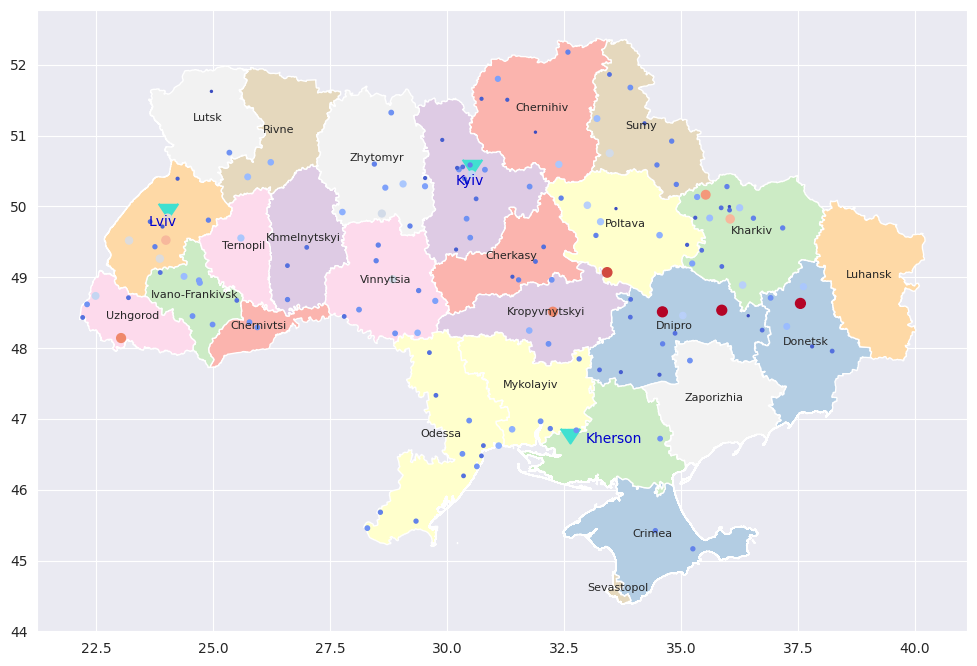

In [17]:
fig, ax = plt.subplots(figsize=(12, 12))

plot_map(df_regions, ax)

df_destinations.plot(ax=ax, marker='o', markersize=2 * df_destinations['capacity'], column='capacity', cmap='coolwarm')

## Plot new random destination points

In [196]:
capacities = list(df_destinations['capacity'].values)

In [213]:
df_new = pd.DataFrame(columns=df_cities.columns)
new_cap = []
i = 0
while i < 100:
    region = choice(df_destinations["region"])
    possible_cities = df_cities[df_cities["region"] == region]
    if len(possible_cities.index) >=1:
        city = choice(possible_cities.index)
        df_new.loc[len(df_new.index)] = df_cities.iloc[city]
        capacity = choice(capacities)
        new_cap.append(capacity)
        i += 1

In [226]:
df_new['capacity'] = new_cap
points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df_new['location'].to_numpy())]

df_new = GeoDataFrame(df_new, geometry=points, crs=df_regions.crs)
df_new.head()

,name,location,population,latitude,longitude,region,geometry,capacity
0,Lokachi,"{""__type"":""GeoPoint"",""latitude"":50.737,""longit...",4056,50.737,24.64944,Volynska,POINT (24.64944 50.73700),3
1,Katyuzhanka,"{""__type"":""GeoPoint"",""latitude"":50.80595,""long...",4046,50.80595,30.13763,Kyivska,POINT (30.13763 50.80595),3
2,Bili Oslavy,"{""__type"":""GeoPoint"",""latitude"":48.48722,""long...",4351,48.48722,24.70078,Ivano-Frankivska,POINT (24.70078 48.48722),5
3,Zmiyiv,"{""__type"":""GeoPoint"",""latitude"":49.67453,""long...",16095,49.67453,36.34775,Kharkivska,POINT (36.34775 49.67453),5
4,Torez,"{""__type"":""GeoPoint"",""latitude"":48.03876,""long...",68037,48.03876,38.59685,Donetska,POINT (38.59685 48.03876),5


<AxesSubplot: >

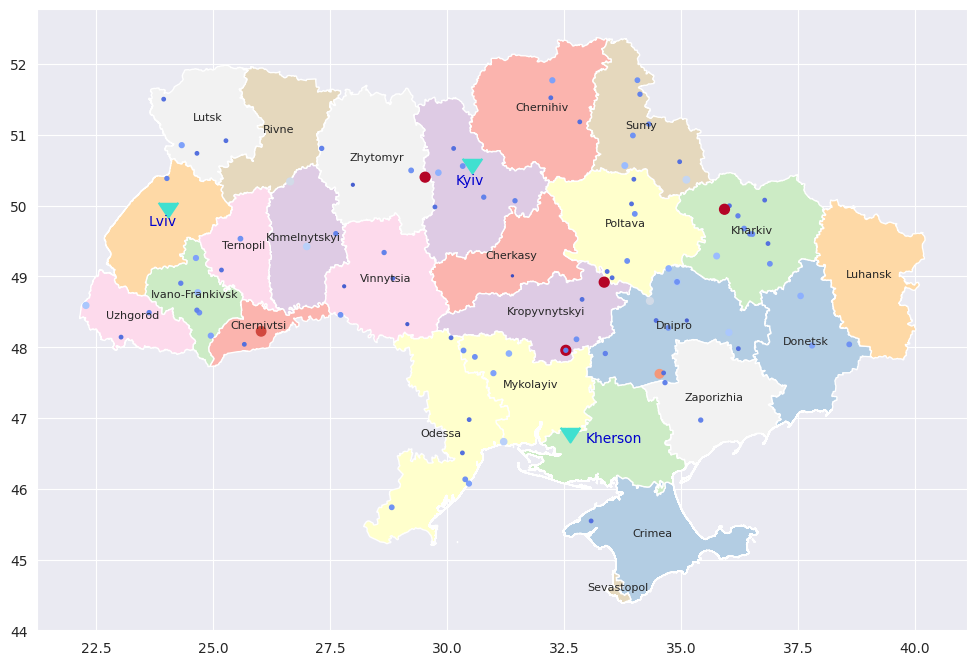

In [215]:
fig, ax1 = plt.subplots(figsize=(12, 12))

plot_map(df_regions, ax1)

df_new.plot(ax=ax1, marker='o', markersize=2*df_new['capacity'], column='capacity', cmap='coolwarm')

In [216]:
best_new_warehouses = None
best_clustering = None
best_total_distance = float('inf')
prev_best_total_distance = float('inf')

for num_new_warehouses in range(1, 2):
    for _ in range(10):
        new_warehouses = random.sample(tuple(possible_warehouses), num_new_warehouses)
        all_warehouses = warehouses.union(new_warehouses)
        all_warehouses_df = df_cities.loc[df_cities.name.isin(all_warehouses)][['name', 'region', 'latitude', 'longitude']]

        def get_closest_warehouse(target):
            distances = all_warehouses_df.apply(lambda w: distance.geodesic(target[4:], w[2:]).km, axis=1)
            warehouse_idx = distances.argmin()
            return pd.Series({'name': target[:1].values[0], 'region': target[1], 'geometry': target[2], 'capacity': target[3], 'closest_warehouse': all_warehouses_df.iloc[warehouse_idx]['name'], 'distance': distances.min()})

        targets = df_new[['name', 'region', 'geometry', 'capacity', 'latitude', 'longitude']]
        clustering = targets.apply(get_closest_warehouse, axis=1)
        total_distance = clustering['distance'].sum()

        if total_distance < best_total_distance:
            best_new_warehouses = new_warehouses
            best_clustering = clustering
            best_total_distance = total_distance

    if best_total_distance >= prev_best_total_distance:
        break
    prev_best_total_distance = best_total_distance

best_new_warehouses = frozenset(best_new_warehouses)
print(best_new_warehouses)

frozenset({'Poltava'})


In [217]:
best_clustering

,name,region,geometry,capacity,closest_warehouse,distance
0,Lokachi,Volynska,POINT (24.64944 50.73700),3,Lviv,109.478660
1,Katyuzhanka,Kyivska,POINT (30.13763 50.80595),3,Kyiv,47.682496
2,Bili Oslavy,Ivano-Frankivska,POINT (24.70078 48.48722),5,Lviv,158.168412
3,Zmiyiv,Kharkivska,POINT (36.34775 49.67453),5,Poltava,130.841974
4,Torez,Donetska,POINT (38.59685 48.03876),5,Poltava,344.367632
...,...,...,...,...,...,...
95,Horenka,Kyivska,POINT (30.33217 50.55731),5,Kyiv,17.753623
96,Terny,Sumska,POINT (33.97070 50.98916),5,Poltava,160.446063
97,Burshtyn,Ivano-Frankivska,POINT (24.62777 49.25867),6,Lviv,77.904202
98,Komsomol’s’ke,Kharkivska,POINT (36.52618 49.59701),5,Poltava,143.535763


In [218]:
clusters = {}  # new_warehouses_total
all_warehouses = frozenset(warehouses.union(best_new_warehouses))
colors = matplotlib.cm.get_cmap('Set2')

for i, wh in enumerate(all_warehouses):
    regions_in_range = frozenset(best_clustering[best_clustering['closest_warehouse'] == wh]['region'].to_numpy())
    # names_in_range = [df_regions[df_regions['REGION'] == reg]['NAME_1'].to_numpy()[0] for reg in regions_in_range]
    clusters[wh] = (colors(i), regions_in_range)

clusters

{'Poltava': ((0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
  frozenset({'Dnipropetrovska',
             'Donetska',
             'Kharkivska',
             'Kirovohradska',
             'Poltavska',
             'Sumska'})),
 'Lviv': ((0.9882352941176471, 0.5529411764705883, 0.3843137254901961, 1.0),
  frozenset({'Chernivetska',
             'Ivano-Frankivska',
             'Khmelnytska',
             'Lvivska',
             'Ternopilska',
             'Volynska',
             'Zakarpatska'})),
 'Kherson': ((0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0),
  frozenset({'Crimea',
             'Dnipropetrovska',
             'Kirovohradska',
             'Mykolaivska',
             'Odeska',
             'Zaporizka'})),
 'Kyiv': ((0.9058823529411765, 0.5411764705882353, 0.7647058823529411, 1.0),
  frozenset({'Cherkaska',
             'Chernihivska',
             'Khmelnytska',
             'Kyivska',
             'Vinnytska',
             'Zhytomyrska'}))}

In [222]:
def plot_cluster(ax: plt.axes, regions: frozenset, color: tuple):
    df = df_regions[df_regions['REGION'].isin(regions)]
    df = df.dissolve(aggfunc='sum')

    ax = df.plot(ax=ax, color=color, alpha=0.6)
    ax = df.boundary.plot(ax=ax, color=color)


/mnt/nvme0n1p5/SRINUX/ucu_courses/3_year/sma/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)
/mnt/nvme0n1p5/SRINUX/ucu_courses/3_year/sma/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)
/mnt/nvme0n1p5/SRINUX/ucu_courses/3_year/sma/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupB

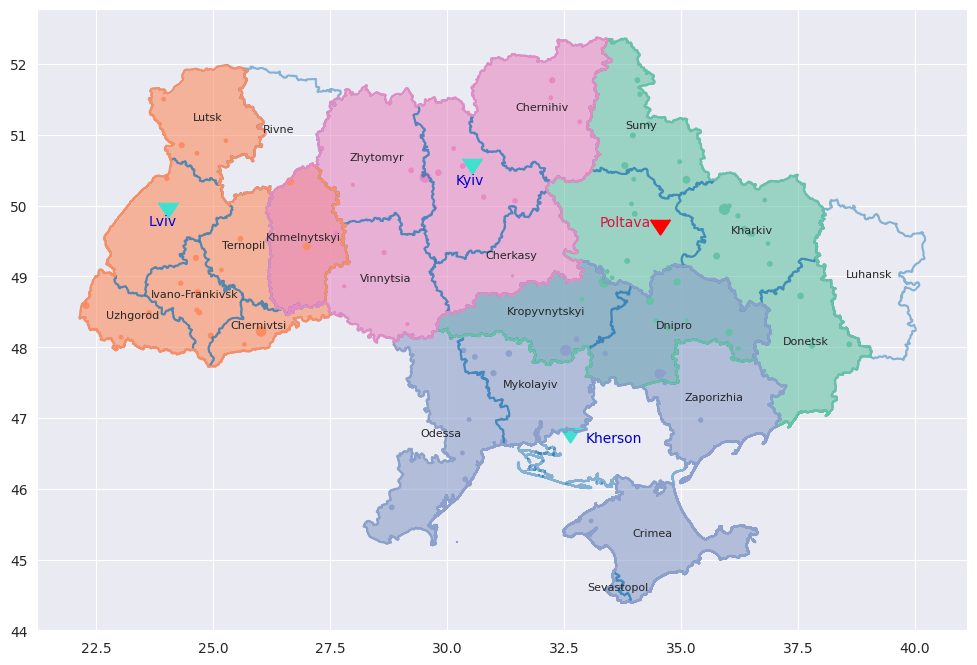

In [223]:
fig, ax = plt.subplots(figsize=(12, 12))

ax = df_regions.boundary.plot(ax=ax, alpha=0.5)

for key, tup in clusters.items():
    plot_cluster(ax, tup[-1], tup[0])

old_warehouses_points = df_cities[df_cities['name'].isin(warehouses)]
old_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='turquoise')

new_warehouses_points = df_cities[df_cities['name'].isin(best_new_warehouses)]
new_warehouses_points.plot(ax=ax, marker=markers.CARETDOWN, markersize=200, color='red')

df_regions.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=8) if x['NAME_1'] not in warehouses.union(best_new_warehouses) else None, axis=1)
df_regions.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='mediumblue', fontsize=10) if x['NAME_1'] in warehouses else None, axis=1)
df_regions.apply(lambda x: plt.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', color='crimson', fontsize=10) if x['NAME_1'] in best_new_warehouses else None, axis=1)


best_clustering.plot(ax=ax, marker='o', markersize=2*best_clustering['capacity'], color=list(map(lambda x: clusters.get(x)[0], best_clustering['closest_warehouse'].to_numpy())));